In [1]:
# import pandas as pd
# import pymysql
# import os

# # List of CSV files and their corresponding table names
# csv_files = [
#     ('customers.csv', 'customers'),
#     ('orders.csv', 'orders'),
#     ('sellers.csv', 'sellers'),
#     ('products.csv', 'products'),
#     ('order_items.csv', 'order_items'),
#     ('payments.csv', 'payments'),
#     ('geolocation.csv', 'geolocation')# Added payments.csv for specific handling
# ]

# # Connect to the MySQL database
# conn = pymysql.connect(
#     host='localhost',
#     user='root',
#     password='Amulya@2002',
#     database='ecommerce'
# )
# cursor = conn.cursor()

# # Folder containing the CSV files
# folder_path = 'D:/Projects/Ecomerce_Project_using_SQL_and_Python'

# def get_sql_type(dtype):
#     if pd.api.types.is_integer_dtype(dtype):
#         return 'INT'
#     elif pd.api.types.is_float_dtype(dtype):
#         return 'FLOAT'
#     elif pd.api.types.is_bool_dtype(dtype):
#         return 'BOOLEAN'
#     elif pd.api.types.is_datetime64_any_dtype(dtype):
#         return 'DATETIME'
#     else:
#         return 'TEXT'

# for csv_file, table_name in csv_files:
#     file_path = os.path.join(folder_path, csv_file)
    
#     # Read the CSV file into a pandas DataFrame
#     df = pd.read_csv(file_path)
    
#     # Replace NaN with None to handle SQL NULL
#     df = df.where(pd.notnull(df), None)
    
#     # Debugging: Check for NaN values
#     print(f"Processing {csv_file}")
#     print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

#     # Clean column names
#     df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

#     # Generate the CREATE TABLE statement with appropriate data types
#     columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
#     create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
#     cursor.execute(create_table_query)

#     # Insert DataFrame data into the MySQL table
#     for _, row in df.iterrows():
#         # Convert row to tuple and handle NaN/None explicitly
#         values = tuple(None if pd.isna(x) else x for x in row)
#         sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
#         cursor.execute(sql, values)

#     # Commit the transaction for the current CSV file
#     conn.commit()

# # Close the connection
# conn.close()

In [2]:
import pandas as pd
import seaborn as  sns
import numpy as np
import matplotlib.pyplot as plt
import pymysql

db = pymysql.connect(
     host='localhost',
     user='root',
     password='Amulya@2002',
     database='ecommerce'
)


cur = db.cursor()


# 1. List all unique cities where customers are located.

In [3]:
query = '''SELECT DISTINCT customer_city FROM customers''' 

cur.execute(query)

data = cur.fetchall()

unique_cities = pd.DataFrame(data)
unique_cities.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [4]:
query = '''SELECT COUNT(*) FROM orders WHERE YEAR(order_purchase_timestamp) = 2017''' 

cur.execute(query)

data = cur.fetchall()

"Total Order Placed in 2017 are: ", data[0][0]

('Total Order Placed in 2017 are: ', 45101)

# 3. Find the total sales per category.

In [5]:
query = '''
SELECT UPPER(products.product_category) AS category, ROUND(SUM(payments.payment_value),2) total_sales
FROM products 
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON order_items.order_id = payments.order_id
GROUP BY category
ORDER BY category ASC, total_sales DESC
''' 

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category","Total_saLes"])
df.dropna(inplace = True)
df.head()

,Category,Total_saLes
1,AGRO INDUSTRIA E COMERCIO,118730.61
2,ART,30992.93
3,ARTS AND CRAFTS,2326.17
4,AUDIO,60324.62
5,AUTOMOTIVE,852294.33


# 4. Calculate the percentage of orders that were paid in installments.

In [6]:
query = '''
SELECT (SUM(CASE WHEN payment_installments >= 1 THEN 1 ELSE 0 END)/COUNT(*) * 100) AS Total_Percentage FROM payments
''' 

cur.execute(query)

data = cur.fetchall()
data[0]

(Decimal('99.9981'),)

# 5. Count the number of customers from each state. 

In [7]:
query = '''
SELECT customer_state, COUNT(*) AS Count FROM customers
GROUP BY customer_state
ORDER BY Count DESC
''' 

cur.execute(query)

data = cur.fetchall()
Customer_state_count = pd.DataFrame(data,columns = ["State", "Total_count"])
Customer_state_count.head()


,State,Total_count
0,SP,41746
1,RJ,12852
2,MG,11635
3,RS,5466
4,PR,5045


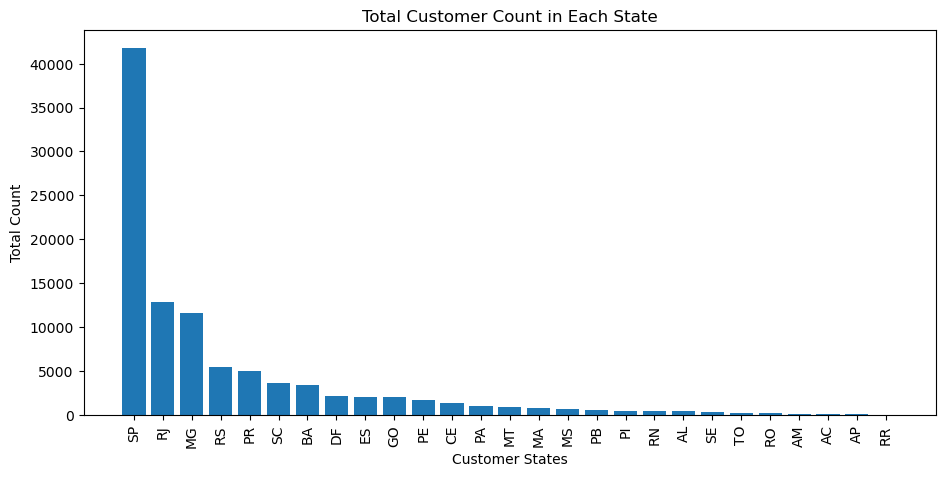

In [8]:
plt.figure(figsize = (11,5))
plt.bar(Customer_state_count['State'],Customer_state_count['Total_count'])
plt.xlabel("Customer States")
plt.ylabel("Total Count")
plt.title("Total Customer Count in Each State")
plt.xticks(rotation = 90)
plt.show()

# Intermediate Queries
# 1. Calculate the number of orders per month in 2018.

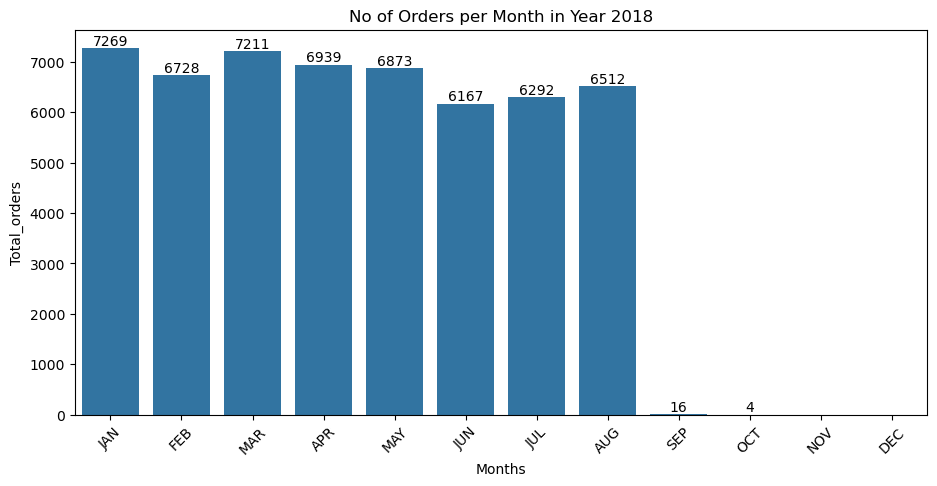

In [9]:
query = '''
SELECT UPPER(LEFT(MONTHNAME(order_purchase_timestamp),3)) AS Short_name , COUNT(*) AS Total_orders FROM orders
WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY Short_name
''' 

cur.execute(query)

data = cur.fetchall()
order_per_month = pd.DataFrame(data,columns = ["Months", "Total_orders"])
order_per_month
o = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

plt.figure(figsize = (11,5))
ax = sns.barplot(x = order_per_month['Months'], y = order_per_month['Total_orders'],data = order_per_month, order = o )
ax.bar_label(ax.containers[0])
plt.title("No of Orders per Month in Year 2018")
plt.xticks(rotation = 45)
plt.show()

# 2. Find the average number of products per order, grouped by customer city.

In [10]:
query = '''
WITH count_per_order AS 
(SELECT order_items.order_id , orders.customer_id, COUNT(order_items.order_item_id) AS oc
FROM order_items
INNER JOIN orders ON order_items.order_id = orders.order_id
GROUP BY order_items.order_id , orders.customer_id
)

SELECT customers.customer_city , ROUND(AVG(count_per_order.oc),2) AS avg_orders
FROM customers
INNER JOIN count_per_order ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city
ORDER BY avg_orders DESC;
''' 

cur.execute(query)

data = cur.fetchall()
avg_per_city = pd.DataFrame(data,columns = ["Customer_city", "Avg_orders"])
avg_per_city.head()

,Customer_city,Avg_orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00


# 3. Calculate the percentage of total revenue contributed by each product category.

In [11]:
query = '''
SELECT UPPER(products.product_category) AS category, ROUND((SUM(payments.payment_value)/(SELECT SUM(payment_value) FROM  payments))*100,2) total_percentage_sales
FROM products 
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON order_items.order_id = payments.order_id
GROUP BY category
ORDER BY total_percentage_sales DESC;
''' 

cur.execute(query)

data = cur.fetchall()
total_revenue = pd.DataFrame(data, columns = ["Product_category","Total_Percentage"])
total_revenue.head()

,Product_category,Total_Percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# 4. Identify the correlation between product price and the number of times a product has been purchased.

In [12]:
query = '''
SELECT products.product_category , COUNT(order_items.product_id) AS Count, AVG(order_items.price) AS Avg_price
FROM products
INNER JOIN order_items ON products.product_id = order_items.product_id
GROUP BY products.product_category
ORDER BY Avg_price DESC;
''' 

cur.execute(query)

data = cur.fetchall()
products_price = pd.DataFrame(data, columns = ["Product_Category", "Count", "Avg_price"])
products_price.head()

arr1 = products_price['Count']
arr2 = products_price['Avg_price']
a = np.corrcoef([arr1,arr2])

print(f"Correlation between product price and the number of times a product has been purchased is : {a[0][1]}")

Correlation between product price and the number of times a product has been purchased is : -0.1063155223754953


# 5. Calculate the total revenue generated by each seller, and rank them by revenue.

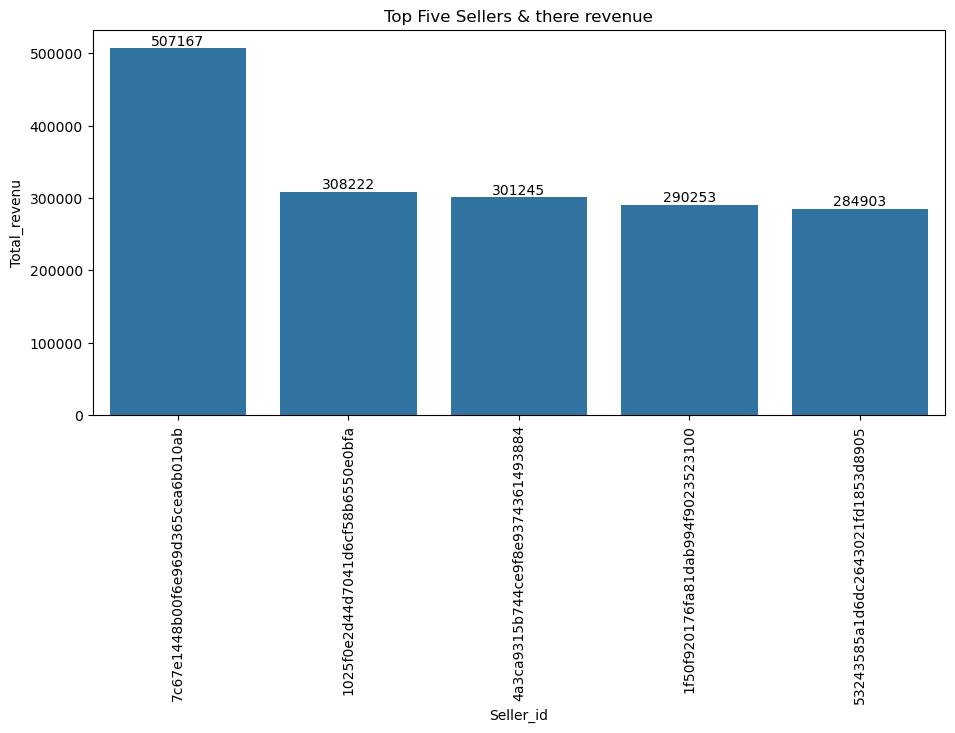

In [13]:
query = '''
With total_revenue AS
(SELECT order_items.seller_id, ROUND(SUM(payments.payment_value),2) AS Total_revenue
FROM order_items
INNER JOIN payments ON order_items.order_id = payments.order_id
GROUP BY order_items.seller_id
)

SELECT * ,dense_rank() OVER(ORDER BY Total_revenue DESC)  AS Ranks FROM total_revenue
''' 

cur.execute(query)

data = cur.fetchall()
rank_revenue = pd.DataFrame(data, columns = ["Seller_id", "Total_revenu", "Rank"])
top_five = rank_revenue.head()
plt.figure(figsize = (11,5))
ax = sns.barplot(x = 'Seller_id', y = 'Total_revenu', data = top_five)
ax.bar_label(ax.containers[0])
plt.title("Top Five Sellers & there revenue")
plt.xticks(rotation = 90)
plt.show()


# Advanced Queries

# 1. Calculate the moving average of order values for each customer over their order history.

In [15]:
query = '''
WITH a AS
(SELECT orders.customer_id, orders.order_purchase_timestamp,payments.payment_value
FROM orders
INNER JOIN payments ON payments.order_id = orders.order_id
)

SELECT customer_id,order_purchase_timestamp,payment_value,
AVG(payment_value) OVER(PARTITION BY customer_id ORDER BY order_purchase_timestamp ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS moving_avg
FROM a
''' 

cur.execute(query)

data = cur.fetchall()
m_avg = pd.DataFrame(data, columns = ["Customer_id", "Order_purchase_timestamp", "Payment", "Moving_avg"])
m_avg

,Customer_id,Order_purchase_timestamp,Payment,Moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# 2. Calculate the cumulative sales per month for each year.

In [19]:
query = '''
WITH a AS 
(SELECT YEAR(orders.order_purchase_timestamp) AS Years, MONTH(orders.order_purchase_timestamp) AS Months, ROUND(SUM(payments.payment_value),2) AS Payments
FROM orders
JOIN payments ON payments.order_id = orders.order_id
GROUP BY Years,Months
)

SELECT * , SUM(Payments) OVER(ORDER BY Years,Months) AS Cummulative_sum 
FROM a
''' 

cur.execute(query)

data = cur.fetchall()
c_sum = pd.DataFrame(data, columns = ["Years", "Months", "Payment", "Cummulative Sum"])
c_sum.head()

,Years,Months,Payment,Cummulative Sum
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


# 3. Calculate the year-over-year growth rate of total sales.

In [20]:
query = '''
WITH b AS
(SELECT YEAR(orders.order_purchase_timestamp) AS Years,ROUND(SUM(payments.payment_value),2) AS Payments
FROM orders
JOIN payments ON payments.order_id = orders.order_id
GROUP BY Years
)

SELECT Years, ((Payments - LAG(Payments, 1) OVER(ORDER BY Years)) /LAG(Payments, 1) OVER(ORDER BY Years)) * 100 AS yoy
FROM b
''' 

cur.execute(query)

data = cur.fetchall()
yoy = pd.DataFrame(data, columns = ["Years", "YOY % Growth"])
yoy

,Years,YOY % Growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [22]:
query = '''
with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id
''' 

# Since none of our customers are repeated thats why value is none
cur.execute(query)

data = cur.fetchall()
data

((None,),)

# 5. Identify the top 3 customers who spent the most money in each year.

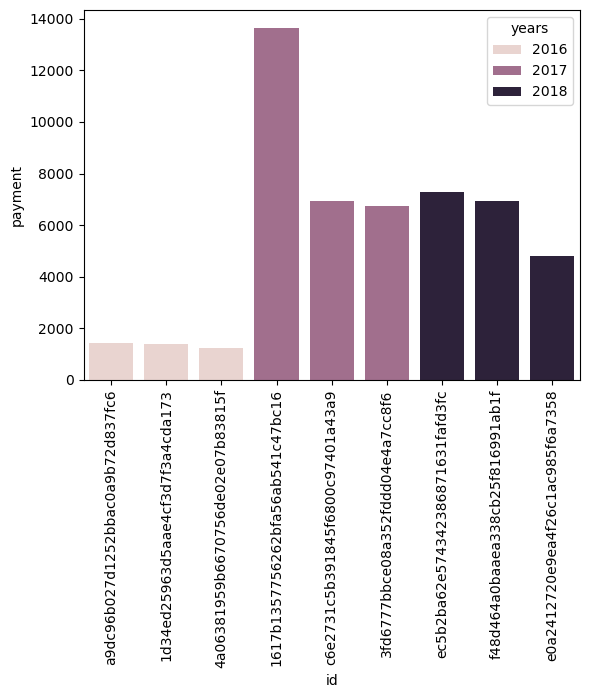

In [23]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()